In [45]:
NOTEBOOK_NAME = "e017_add_magic_num"

In [46]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [47]:
train = pl.read_csv("../data/train.csv")
test = pl.read_csv("../data/test.csv")
era = pl.read_csv("../data/era.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# 前処理

In [48]:
import re


def get_prefecture(text: str) -> str | None:
    all_prefectures = (
        "北海道|青森県|岩手県|宮城県|秋田県|山形県|福島県|"
        + "茨城県|栃木県|群馬県|埼玉県|千葉県|東京都|神奈川県|"
        + "新潟県|富山県|石川県|福井県|山梨県|長野県|岐阜県|静岡県|愛知県|"
        + "三重県|滋賀県|京都府|大阪府|兵庫県|奈良県|和歌山県|"
        + "鳥取県|島根県|岡山県|広島県|山口県|"
        + "徳島県|香川県|愛媛県|高知県|"
        + "福岡県|佐賀県|長崎県|熊本県|大分県|宮崎県|鹿児島県|沖縄県"
    )
    if match := re.search(all_prefectures, text):
        return match.group(0)
    else:
        return None


# 都道府県を抽出
train = train.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)
test = test.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)

In [49]:
# 種別2より建造物か美工品かを分類する特徴を追加
kenzoubutu_feat = [
    "近世以前／神社",
    "近世以前／神社",
    "近世以前／寺院",
    "近世以前／城郭",
    "近世以前／住宅",
    "近世以前／民家",
    "近世以前／その他",
    "近代／宗教",
    "近代／学校",
    "近代／官公庁舎",
    "近代／産業・交通・土木",
    "近代／住居",
    "近代／文化施設",
    "近代／商業・業務",
    "近代／その他",
]

bikouhin_feat = ["宝", "絵画", "彫刻", "工芸品", "書跡・典籍", "古文書", "考古資料", "歴史資料"]


def classify_kenzoubutu_bikouhin(text: str | None) -> str | None:
    if text in kenzoubutu_feat:
        return "建造物"
    elif text in bikouhin_feat:
        return "美工品"
    return None


train = train.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)
test = test.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_16124/3755196075.py:31: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_16124/3755196075.py:34: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")


# データ型の変更

In [50]:
train.head()

名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度,is_kokuhou,都道府県,建造物_or_美工品
str,str,str,str,str,str,str,str,str,str,f64,f64,i64,str,str
"""泉布観""",null,"""近代／文化施設""",null,"""明治""","""大阪府""","""大阪府大阪市北区天満橋一丁目…",null,"""大阪市""",null,34.69811,135.5214,0,"""大阪府""","""建造物"""
"""絹本著色准胝仏母像""",null,"""絵画""","""日本""","""鎌倉""","""京都府（京都府）""",null,null,"""広隆寺""",null,null,null,0,"""京都府""","""美工品"""
"""石上神宮拝殿""",null,"""近世以前／寺院""",null,"""鎌倉前期""","""奈良県""","""奈良県天理市布留町""",null,"""石上神宮""",null,34.5978,135.852,1,"""奈良県""","""建造物"""
"""剣〈銘真守（備前）／〉""",null,"""工芸品""","""日本""","""鎌倉""","""和歌山県（和歌山県）""",null,null,"""宗教法人金剛峯寺""","""財団法人高野山文化財保存会""",null,null,0,"""和歌山県""","""美工品"""
"""旧新町紡績所""","""工場本館""","""近代／産業・交通・土木""",null,"""明治""","""群馬県""","""群馬県高崎市新町二三三〇番地…",null,"""クラシエフーズ株式会社""",null,36.27766,139.1003,0,"""群馬県""","""建造物"""


In [51]:
categorical_cols = ["国", "時代", "保管施設の名称", "所有者名", "管理団体又は責任者", "都道府県", "建造物_or_美工品"]

In [52]:
for col in categorical_cols:
    train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
    test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [53]:
FOLD_NUM = 5

In [54]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("is_kokuhou"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# LightGBM

In [55]:
use_col = []

base_col = ["緯度", "経度"]

use_col += base_col
use_col += categorical_cols

len(use_col)

9

In [56]:
use_col

['緯度', '経度', '国', '時代', '保管施設の名称', '所有者名', '管理団体又は責任者', '都道府県', '建造物_or_美工品']

In [57]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {"objective": "binary", "metric": "auc"}

In [58]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # polarsをpandasに変換
    train_pd = train.to_pandas()

    # foldごとにtrainとvalidに分ける
    train_fold = train_pd[train_pd["fold"] != fold]
    valid_fold = train_pd[train_pd["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("is_kokuhou", axis=1)
    X_valid = valid_fold.drop("is_kokuhou", axis=1)
    y_train = train_fold[["is_kokuhou"]]
    y_valid = valid_fold[["is_kokuhou"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    calc_f1_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {calc_f1_score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	training's auc: 0.914084	valid_1's auc: 0.809195
fold 0 Score: 0.8091948470209339
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[100]	training's auc: 0.91237	valid_1's auc: 0.783631
fold 1 Score: 0.7836312399355876
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	training's auc: 0.933545	valid_1's auc: 0.804473
fold 2 Score: 0.8044726247987117
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	training's auc: 0.908726	valid_1's auc: 0.786385
fold 3 Score: 0.7863848631239936
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	training's auc: 0.966729	valid_1's auc: 0.76467
fold 4 Score: 0.7646699802937587


In [59]:
oof_score = roc_auc_score(y_true=train.get_column("is_kokuhou"), y_score=oof)
oof_score

0.7824746705654563

In [60]:
from sklearn.metrics import f1_score

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(train.get_column("is_kokuhou"), (oof > thr).astype(int))
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr

print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

thr: 0.01, f1_score: 0.17430001854255514
thr: 0.02, f1_score: 0.2125147579693034
thr: 0.03, f1_score: 0.23193916349809887
thr: 0.04, f1_score: 0.2563619227144203
thr: 0.05, f1_score: 0.2697967764540995
thr: 0.060000000000000005, f1_score: 0.2784714339765418
thr: 0.06999999999999999, f1_score: 0.2882882882882883
thr: 0.08, f1_score: 0.2910882221227049
thr: 0.09, f1_score: 0.29672447013487474
thr: 0.09999999999999999, f1_score: 0.29878048780487804
thr: 0.11, f1_score: 0.3001095290251917
thr: 0.12, f1_score: 0.3014184397163121
thr: 0.13, f1_score: 0.30426479949077023
thr: 0.14, f1_score: 0.2995169082125604
thr: 0.15000000000000002, f1_score: 0.2933914306463326
thr: 0.16, f1_score: 0.29268292682926833
thr: 0.17, f1_score: 0.29365079365079366
thr: 0.18000000000000002, f1_score: 0.29569455727051175
thr: 0.19, f1_score: 0.298582151793161
thr: 0.2, f1_score: 0.29955947136563876
thr: 0.21000000000000002, f1_score: 0.3049907578558225
thr: 0.22, f1_score: 0.29913710450623204
thr: 0.23, f1_score: 

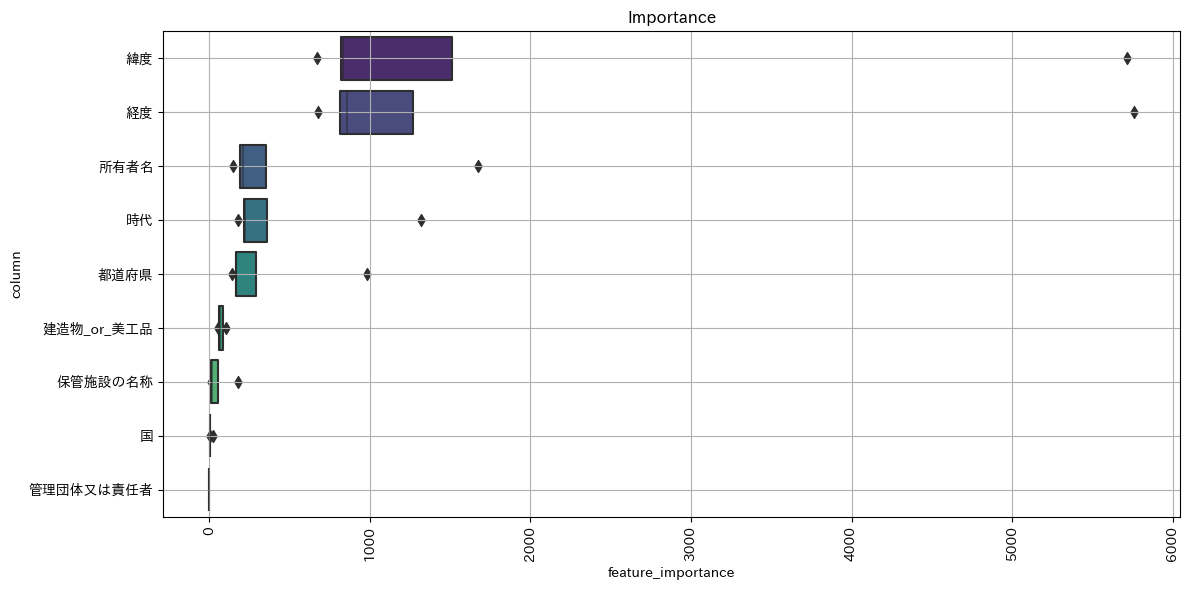

In [61]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, use_col)

In [62]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test.select(use_col).to_pandas()) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

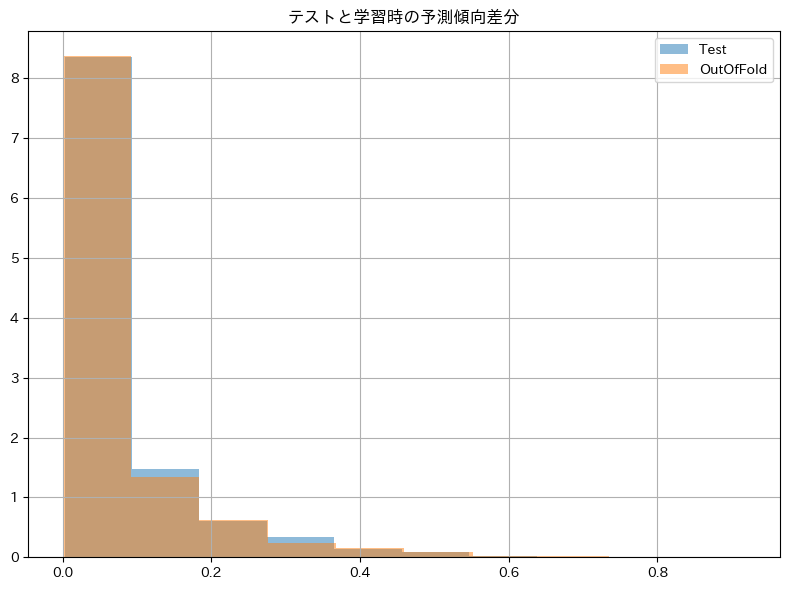

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [64]:
train.with_columns(pl.Series(oof).cast(pl.Float64).alias("oof")).write_csv(
    f"../oof/oof_{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)

In [65]:
sample_submission = sample_submission.with_columns(
    pl.Series("is_kokuhou", pred > (best_thr - 0.01)).cast(int)
)
sample_submission

is_kokuhou
i64
0
0
0
0
0
0
0
0
0


In [66]:
sample_submission.write_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)